In [1]:
import torch
from graphxai.datasets import ShapeGGen
from graphxai.explainers import GNNExplainer, PGExplainer, GraphLIME, IntegratedGradExplainer, SubgraphX, PGMExplainer
from graphxai.metrics import graph_exp_acc, graph_exp_faith
# from graphxai.visualization import ExplanationVisualizer
import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

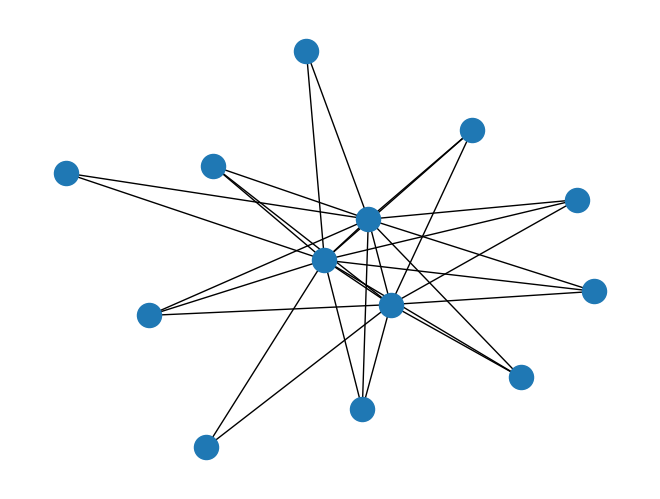

In [13]:
import networkx as nx

nx.draw(nx.barabasi_albert_graph(13, m=10))

In [2]:
from CentralNodeDataset import CentralNodeDataset
# from Central2 import CentralNodeDataset

dataset = CentralNodeDataset(num_graphs=1000, min_nodes=10, max_nodes=30)
graph = dataset.get_graph()

# print(f"Всего узлов: {graph.x.size(0)}")
# print(f"Распределение классов: {torch.bincount(graph.y)}")
# print(f"Размеры масок: Train {graph.train_mask.sum()}, Val {graph.valid_mask.sum()}, Test {graph.test_mask.sum()}")


In [15]:
central_idx = (graph.y == 1).nonzero()[0][0].item()
print(f"\nПример центрального узла ({central_idx}):")
print(f"Признаки: {graph.x[central_idx]}")
print(f"Объяснение: {dataset.explanations[central_idx]}")



Пример центрального узла (0):
Признаки: tensor([ 2.2655, -0.2441,  1.1971, -0.1094, -0.0834])
Объяснение: Node 0: Central, Eccentricity: 1


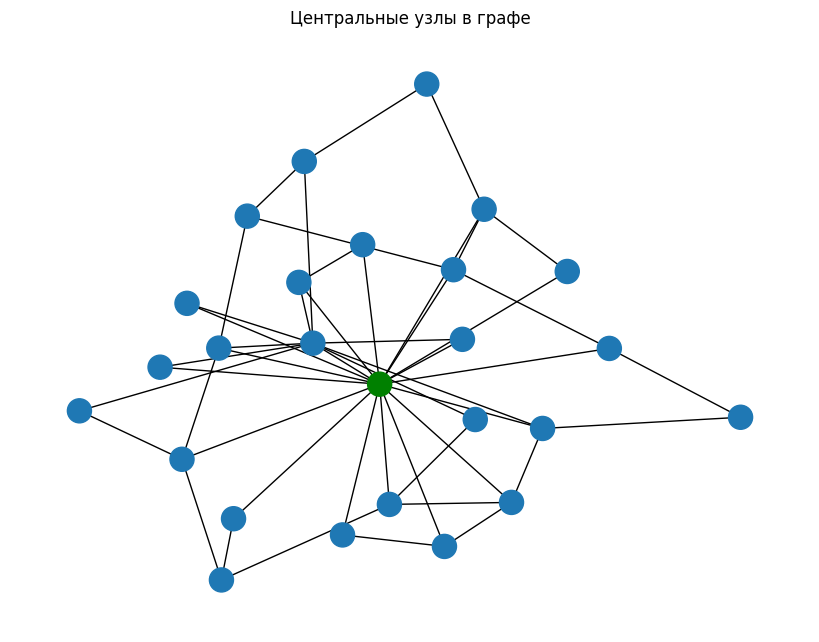

In [3]:
import networkx as nx

def draw_simple_graph(graph_data, with_labels=False):
    # Создаем граф из edge_index
    edge_list = graph_data.edge_index.T.tolist()
    G = nx.Graph()
    G.add_edges_from(edge_list)
    
    # Получаем метки узлов (1 - центральный, 0 - нет)
    node_labels = graph_data.y.numpy()
    
    nodes = list(G.nodes())  # Список узлов графа в текущем порядке
    node_colors = ['green' if node_labels[node] == 1 else '#1f78b4' for node in nodes]
    # Цвета узлов
    # node_colors = ['green' if label == 1 else '#1f78b4' for label in node_labels]
    # print(node_colors)
    # Рисуем граф
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos,
            node_color=node_colors,
            with_labels=with_labels,
            font_weight='bold')
    
    plt.title("Центральные узлы в графе")
    plt.show()

# Пример использования
draw_simple_graph(dataset.graphs[19])


In [17]:
G = nx.Graph(dataset.graphs[70].edge_index.T.tolist())
# dataset.graphs[1].edge_index.T.tolist()
eccentricity = nx.eccentricity(G)
min_eccentricity = min(eccentricity.values())
central_nodes = [n for n, e in eccentricity.items() if e == min_eccentricity]
print(dataset.graphs[70].y)
print(['green' if label == 1 else '#1f78b4' for label in dataset.graphs[70].y.numpy()])
central_nodes

tensor([1, 0, 0, 0, 0])
['green', '#1f78b4', '#1f78b4', '#1f78b4', '#1f78b4']


[0]

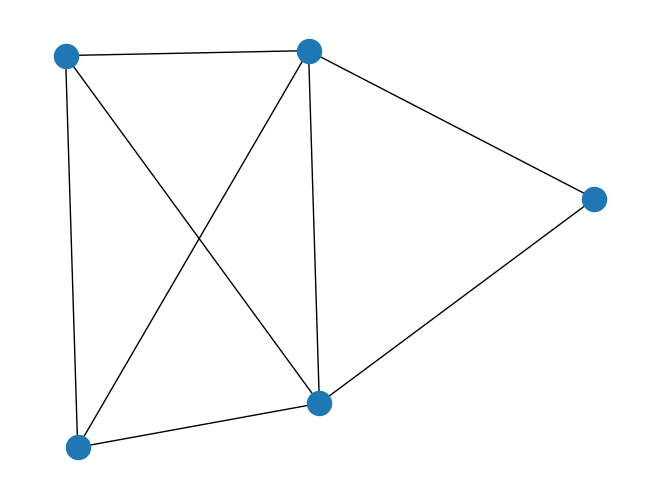

In [18]:
import networkx as nx

nx.draw(nx.Graph(dataset.graphs[0].edge_index.T.tolist()))

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv, GATConv, GATv2Conv, SAGEConv

class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index,):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        
        return x


class GIN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GINConv(torch.nn.Linear(in_dim, hidden_dim))
        self.conv2 = GINConv(torch.nn.Linear(hidden_dim, hidden_dim))
        self.conv3 = GINConv(torch.nn.Linear(hidden_dim, out_dim))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        
        return x

class GAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=8, dropout=0.5):
        super().__init__()
        self.conv1 = GATv2Conv(in_dim, hidden_dim, heads=heads, dropout=dropout)
        self.conv2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=heads, dropout=dropout)
        self.conv3 = GATv2Conv(hidden_dim * heads, out_dim, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.conv3(x, edge_index)
        
        return x


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        
        return x


In [5]:
in_dim  = 5
hidden_dim = 32
out_dim = 2

models = {
    'GIN': GIN(in_dim, hidden_dim, out_dim).to(device),
    'GCN': GCN(in_dim, hidden_dim, out_dim).to(device),
    'GAT': GAT(in_dim, hidden_dim, out_dim).to(device),
    'GraphSAGE': GraphSAGE(in_dim, hidden_dim, out_dim).to(device)
}

In [6]:
from graphxai.gnn_models.node_classification import train, test


data = dataset.get_graph(use_fixed_split=True).to(device)

for model_name, model in models.items():
    print("\n\t" + model_name)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss().to(device)

    for epoch in range(300):
        train(model, optimizer, criterion, data)
        # f1, _, _, _, auc = test(model, val_loader)

        # print(f'epoch: {epoch+1:1d}, val F1: {f1:.4f}, val AUC: {auc:.4f}')

    acc, f1 = test(model, data, num_classes=2, get_auc=False)
    print(f'test F1: {f1:.4f}, test ACC: {acc:.4f}')


	GIN
test F1: 0.8517, test ACC: 0.8517

	GCN


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test F1: 0.8593, test ACC: 0.8593

	GAT


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test F1: 0.8593, test ACC: 0.8593

	GraphSAGE
test F1: 0.8919, test ACC: 0.8919


In [7]:
for model_name, model in models.items():
    acc, f1 = test(model, data, num_classes=2, get_auc=False)
    print(f"{model_name}: {f1}")

GIN: 0.8516819571865444
GCN: 0.8593272171253823
GAT: 0.8593272171253823
GraphSAGE: 0.891946992864424


d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Apps\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
dataset

KeyError: tensor([False, False, False,  ..., False, False, False], device='cuda:0')

In [8]:
from graphxai.explainers import PGExplainer, IntegratedGradExplainer, GNNExplainer, SubgraphX, RandomExplainer


# null_batch = torch.zeros(1).long().cuda()
# forward_kwargs = {'batch': null_batch}

explainers = {model_name: {} for model_name in models}

for idx, (name, model) in enumerate(models.items()):
    in_channels = (4 if name in ["GAT", "GraphSAGE"] else None)
    pgex = PGExplainer(model, emb_layer_name='conv3', in_channels=in_channels, max_epochs=1)
    # pgex.train_explanation_model(data)

    igex = IntegratedGradExplainer(model, criterion=criterion)
    gnnex = GNNExplainer(model)
    rndex = RandomExplainer(model)
    
    subex = SubgraphX(model)

    explainers[name] = {
        "PGExplainer": pgex,
        "GNNExplainer": gnnex,
        "RandomExplainer": rndex,
        "IntegratedGradExplainer": igex,
        "SubgraphX": subex,
    }


In [ ]:
node_idx, gt_exp = dataset.choose_node(split = 'test')
# while len(gt_exp[0].node_imp) > 50:
#     node_idx, gt_exp = dataset.choose_node(split = 'test')
label = torch.tensor([1])

In [61]:
node_idx, gt_exp = dataset.choose_node_with_label(1)
label = torch.tensor([1])
node_idx

8271

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0])


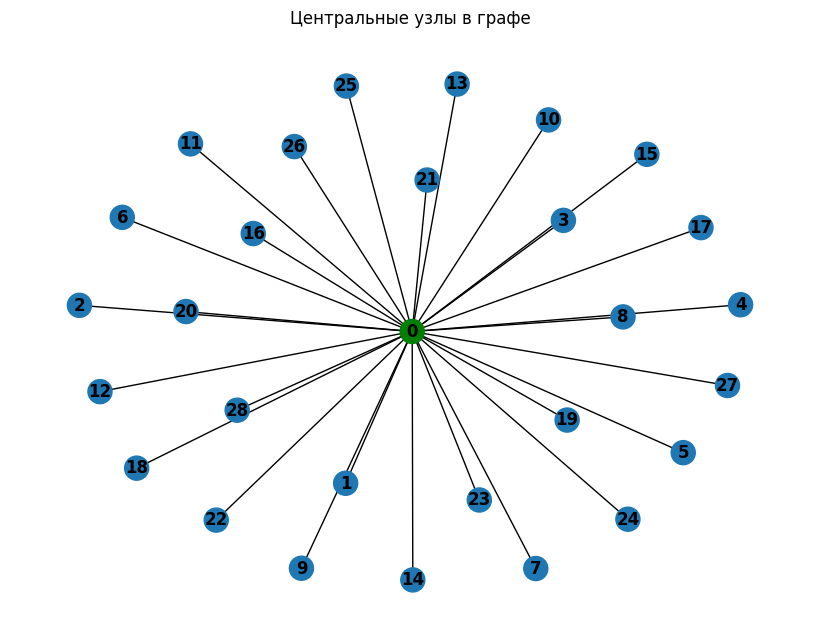

In [28]:
test_graph, exp = dataset[10]

print(test_graph.y)

draw_simple_graph(test_graph, with_labels=True)

In [29]:
from torch_geometric.data import Data

data = Data(
            x=torch.cat([test_graph.x], dim=0),
            edge_index=torch.cat([test_graph.edge_index], dim=1),
            y=torch.cat([test_graph.y], dim=0)
        ).cuda()
node_idx = 0
label = torch.tensor([1]).cuda()


In [ ]:
test()

GIN
args 0 3 tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28]])
GCN


d:\Apps\Python\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


args 0 3 tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,
          9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
         27, 28],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0]])
GAT
args 0 3 tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,
          9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
         27, 28],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,

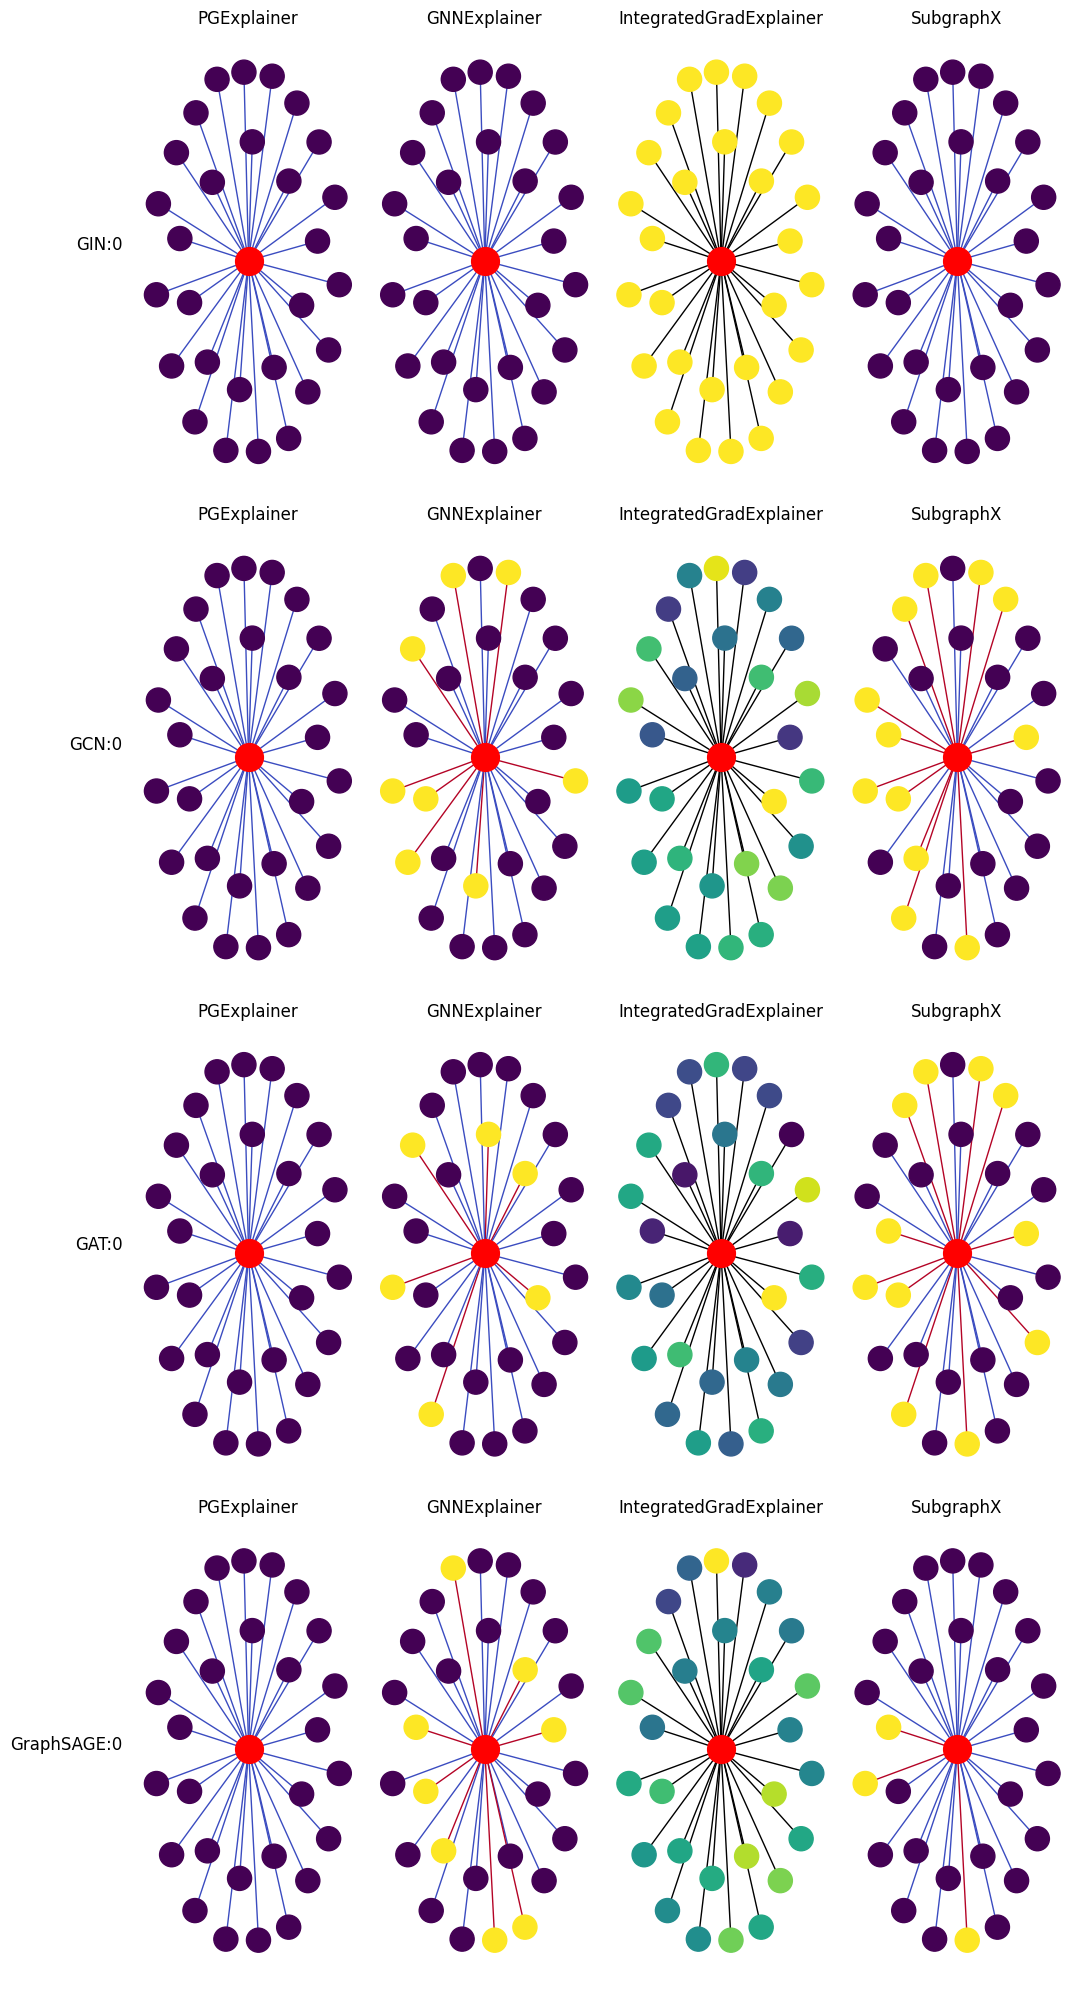

In [30]:
fig, ax = plt.subplots(len(models), 4, figsize = (10, 20))

# data.to('cuda')

for idx, (name, model) in enumerate(models.items()):

    print(name)
    pgex, gnnex, rndex, igex, subex = explainers[name].values()

    pg_exp = pgex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)
    gnn_exp = gnnex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)
    sub_exp = subex.get_explanation_node(node_idx = node_idx, x = data.x.to('cpu'), edge_index = data.edge_index.to('cpu'), y = data.y.to('cpu'))
    ig_exp = igex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)

    # rnd_ex = rndex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index )

    # ax[idx, 0].set_title('Исходный вид')
    # ax[idx, 0].set_title('RandomExplainer')
    ax[idx, 0].set_title('PGExplainer')
    ax[idx, 1].set_title('GNNExplainer')
    ax[idx, 2].set_title('IntegratedGradExplainer')
    ax[idx, 3].set_title('SubgraphX')

    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)[node_idx]
    
    fig.text(0.04, (1 - (idx + 0.5) / len(models)), f"{name}:{pred}", va='center', ha='right', fontsize=12)

    # gt_exp[0].visualize_node(num_hops = 2, graph_data = data, ax = ax[idx, 0])
    # rnd_ex.visualize_node(num_hops = 2, graph_data = data, ax = ax[idx, 0])
    pg_exp.visualize_node(num_hops = 2, graph_data = data, ax = ax[idx, 0])
    gnn_exp.visualize_node(num_hops = 2, graph_data = data, ax = ax[idx, 1])
    ig_exp.visualize_node(num_hops = 2, graph_data = data, ax = ax[idx, 2])
    sub_exp.visualize_node(num_hops = 2, graph_data = data, ax = ax[idx, 3])

plt.tight_layout(rect=[0.04, 0, 1, 1])
plt.show()

In [ ]:
test()

In [27]:
for name, model in models.items():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    probas = out.softmax(dim=1)[:,1].detach().clone().cpu().numpy()
    print(name, pred)

GIN tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
GCN tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
GAT tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
GraphSAGE tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')


In [ ]:
from graphxai.utils.perturb import rewire_edges, perturb_node_features

def graph_exp_faith(generated_exp, shape_graph, model, sens_idx = [], top_k = 0.25, device=device):
    '''
    Args:
        gt_exp (Explanation): Ground truth explanation from the dataset.
        generated_exp (Explanation): Explanation output by an explainer.
    '''

    GEF_feat = None
    GEF_node = None
    GEF_edge = None

    # Accessing the enclosing subgraph. Will be the same for both explanation.:
    exp_subgraph = generated_exp.enc_subgraph

    # Getting the softmax vector for the original graph
    org_vec = model(shape_graph.get_graph().x, shape_graph.get_graph().edge_index)[generated_exp.node_idx]
    org_softmax = F.softmax(org_vec, dim=-1)

    if generated_exp.feature_imp is not None:
        # Identifying the top_k features in the node attribute feature vector
        top_k_features = generated_exp.feature_imp.topk(int(generated_exp.feature_imp.shape[0] * top_k))[1]

        # Getting the softmax vector for the perturbed graph
        pert_x = shape_graph.get_graph().x.clone()

        # Perturbing the unimportant node feature indices using gaussian noise
        rem_features = torch.Tensor(
            [i for i in range(shape_graph.get_graph().x.shape[1]) if i not in top_k_features]).long()

        pert_x[generated_exp.node_idx, rem_features] = perturb_node_features(x=pert_x, node_idx=generated_exp.node_idx, pert_feat=rem_features, bin_dims=sens_idx, device=device)

        pert_vec = model(pert_x, shape_graph.get_graph().edge_index)[generated_exp.node_idx]
        pert_softmax = F.softmax(pert_vec, dim=-1)
        GEF_feat = 1 - torch.exp(-F.kl_div(org_softmax.log(), pert_softmax, None, None, 'sum')).item()

    if generated_exp.node_imp is not None:

        # Identifying the top_k nodes in the explanation subgraph
        top_k_nodes = generated_exp.node_imp.topk(int(generated_exp.node_imp.shape[0] * top_k))[1]

        rem_nodes = []
        for node in range(generated_exp.node_imp.shape[0]):
            if node not in top_k_nodes:
                rem_nodes.append([k for k, v in generated_exp.node_reference.items() if v == node][0])

        # Getting the softmax vector for the perturbed graph
        pert_x = shape_graph.get_graph().x.clone()

        # Removing the unimportant nodes by masking
        pert_x[rem_nodes] = torch.zeros_like(pert_x[rem_nodes])
        pert_vec = model(pert_x, shape_graph.get_graph().edge_index)[generated_exp.node_idx]
        pert_softmax = F.softmax(pert_vec, dim=-1)
        GEF_node = 1 - torch.exp(-F.kl_div(org_softmax.log(), pert_softmax, None, None, 'sum')).item()

    if generated_exp.edge_imp is not None:
        subgraph_edges = torch.where(generated_exp.enc_subgraph.edge_mask == True)[0]
        # Get the list of all edges that we need to keep
        device = generated_exp.edge_imp.device  # Устройство, где находится edge_imp
        subgraph_edges = subgraph_edges.to(device)  # Перемещаем subgraph_edges на нужное устройство

        # Создаем маску для всех ребер
        edge_mask = torch.zeros(shape_graph.get_graph().edge_index.shape[1], dtype=torch.bool, device=device)

        # Помечаем ребра из подграфа, которые НЕ имеют нулевой важности
        edge_mask[subgraph_edges] = (generated_exp.edge_imp != 0)

        # Собираем индексы ребер, которые нужно оставить
        keep_edges = torch.where(edge_mask)[0].tolist()

        # Get new edge_index
        edge_index = shape_graph.get_graph().edge_index[:, keep_edges]
                    
        # Getting the softmax vector for the perturbed graph
        pert_vec = model(shape_graph.get_graph().x, edge_index)[generated_exp.node_idx]
        pert_softmax = F.softmax(pert_vec, dim=-1)        
        GEF_edge = 1 - torch.exp(-F.kl_div(org_softmax.log(), pert_softmax, None, None, 'sum')).item()

    return [GEF_feat, GEF_node, GEF_edge]


def graph_exp_acc(gt_exp, generated_exp) -> float:
    '''
    Args:
        gt_exp (Explanation): Ground truth explanation from the dataset.
        generated_exp (Explanation): Explanation output by an explainer.
    '''

    EPS = 1e-09
    thresh = 0.8
    JAC_feat = None
    JAC_node = None
    JAC_edge = None 

    # Accessing the enclosing subgraph. Will be the same for both explanation.:
    exp_subgraph = generated_exp.enc_subgraph

    if generated_exp.feature_imp is not None:
        JAC_feat = []
        for exp in gt_exp:
            TPs = []
            FPs = []
            FNs = []
            true_feat = torch.where(exp.feature_imp == 1)[0]
            for i, feat in enumerate(exp.feature_imp):
                # Restore original feature numbering
                positive = generated_exp.feature_imp[i].item() > thresh
                if positive:
                    if i in true_feat:
                        TPs.append(generated_exp.feature_imp[i])
                    else:
                        FPs.append(generated_exp.feature_imp[i])
                else:
                    if i in true_feat:
                        FNs.append(generated_exp.feature_imp[i])

            TP = len(TPs)
            FP = len(FPs)
            FN = len(FNs)
            JAC_feat.append(TP / (TP + FP + FN + EPS))

        JAC_feat = max(JAC_feat)

    if generated_exp.node_imp is not None:
        JAC_node = []
        for exp in gt_exp:
            TPs = []
            FPs = []
            FNs = []
            relative_positives = (exp.node_imp == 1).nonzero(as_tuple=True)[0]
            true_nodes = [exp.enc_subgraph.nodes[i].item() for i in relative_positives]

            for i, node in enumerate(exp_subgraph.nodes):
                # Restore original node numbering
                positive = generated_exp.node_imp[i].item() > thresh
                if positive:
                    if node in true_nodes:
                        TPs.append(node)
                    else:
                        FPs.append(node)
                else:
                    if node in true_nodes:
                        FNs.append(node)
            TP = len(TPs)
            FP = len(FPs)
            FN = len(FNs)
            JAC_node.append(TP / (TP + FP + FN + EPS))

        JAC_node = max(JAC_node)

    if generated_exp.edge_imp is not None:
        JAC_edge = []
        for exp in gt_exp:
            TPs = []
            FPs = []
            FNs = []
            true_edges = torch.where(exp.edge_imp == 1)[0]
            for edge in range(exp.edge_imp.shape[0]):
                if generated_exp.edge_imp[edge]:
                    if edge in true_edges:
                        TPs.append(edge)
                    else:
                        FPs.append(edge)
                else:
                    if edge in true_edges:
                        FNs.append(edge)
            TP = len(TPs)
            FP = len(FPs)
            FN = len(FNs)
            JAC_edge.append(TP / (TP + FP + FN + EPS))

        JAC_edge = max(JAC_edge)

    return [JAC_feat, JAC_node, JAC_edge]

In [ ]:
# test_graph, explanation = dataset.get_test_w_label(1)
# test_graph.to('cuda')
# model_name = "GraphSAGE"

import numpy as np
# from graphxai.metrics import graph_exp_acc, graph_exp_faith

# graphs, explanations = dataset.get_data_list(dataset.test_index)

scores = {model_name:{explainer:{} for explainer in explainers[model_name]} for model_name in models}

for model_name in models:
    print()
    print(model_name)
    for exp_name, explainer in explainers[model_name].items():
        if exp_name == "SubgraphX":
            continue

        accuracy = np.zeros(3)
        faithfulness = np.zeros(3)

        num_tests = 100 if exp_name in ['PGExplainer', 'RandomExplainer'] else 5
        # num_tests = 2 if exp_name == "SubgraphX" else num_tests

        for i in range(num_tests):

            node_idx, gt_exp = dataset.choose_node(split = 'test')

            if exp_name in ["RandomExplainer"]:
                gen_exp = explainer.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index)
            else:
                gen_exp = explainer.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)

            acc_feat, acc_nodes, acc_edges = graph_exp_acc(gt_exp, gen_exp)
            accuracy += [acc_feat if acc_feat != None else 0, acc_nodes, acc_edges if acc_edges else 0]

            faith_feat, faith_nodes, faith_edges = graph_exp_faith(gen_exp, dataset, models[model_name])
            faithfulness += [faith_feat if faith_feat != None else 0, faith_nodes, faith_edges if faith_edges else 0]

        accuracy /= num_tests
        faithfulness /= num_tests
        
        scores[model_name][exp_name]['accuracy'] = accuracy
        scores[model_name][exp_name]['faithfulness'] = faithfulness
        
        print('\t' + exp_name)
        print('accuracy:', accuracy)
        print('faithfulness:', faithfulness)



GIN
	PGExplainer
accuracy: [0.         0.18684296 0.55494282]
faithfulness: [ 0.00000000e+00  2.75713760e-01 -2.38418579e-09]
	GNNExplainer
accuracy: [0.         0.20047619 0.07393939]
faithfulness: [0.21268829 0.24773578 0.32018397]
	RandomExplainer
accuracy: [0.21009524 0.06962988 0.51068111]
faithfulness: [1.20292594e-01 2.85349146e-01 3.57627869e-09]
	IntegratedGradExplainer
accuracy: [0.         0.01666667 0.        ]
faithfulness: [0.0195401  0.50561462 0.        ]

GCN
	PGExplainer
accuracy: [0.         0.1874251  0.52164252]
faithfulness: [0.         0.31523128 0.00222058]
	GNNExplainer
accuracy: [0.         0.43199643 0.05062657]
faithfulness: [0.19905486 0.36212087 0.47744947]
	RandomExplainer
accuracy: [0.14449206 0.05949824 0.49620344]
faithfulness: [0.14292555 0.28966612 0.00161233]
	IntegratedGradExplainer
accuracy: [0. 0. 0.]
faithfulness: [0.05847174 0.64121541 0.        ]

GAT
	PGExplainer
accuracy: [0.         0.18735958 0.50783887]
faithfulness: [0.         0.337002

In [ ]:
del scores["GIN"]["SubgraphX"]

In [ ]:
import pandas as pd
methods = list(scores['GIN'].keys())

df_acc = pd.DataFrame()

for model in scores:
    for method in methods:
        acc = scores[model][method]['accuracy']
        df_acc.loc[method, model] = str(tuple(map(lambda x: round(x, 4), acc[1:])))

# Сортировка столбцов по методам
# df_acc = df_acc.reindex(sorted(df_acc.columns, key=lambda x: x.split('_')[0]), axis=1)

df_acc

,GIN,GCN,GAT,GraphSAGE
PGExplainer,"(0.1868, 0.5549)","(0.1874, 0.5216)","(0.1874, 0.5078)","(0.1854, 0.5016)"
GNNExplainer,"(0.2005, 0.0739)","(0.432, 0.0506)","(0.2367, 0.1)","(0.3104, 0.1933)"
RandomExplainer,"(0.074, 0.078)","(0.0134, 0.0631)","(0.0701, 0.0814)","(0.0886, 0.0289)"
IntegratedGradExplainer,"(0.0167, 0.0)","(0.0, 0.0)","(0.0432, 0.0)","(0.113, 0.0)"


In [ ]:
for model in scores:
    scores[model]["RandomExplainer"]['accuracy'] = tuple(0.09*np.random.random(3))

In [ ]:
import pandas as pd
methods = list(scores['GIN'].keys())

df_faith = pd.DataFrame()

for model in scores:
    for method in methods:
        faith = scores[model][method]['faithfulness']
        df_faith.loc[method, model] = str(tuple(map(lambda x: round(x, 4), faith[1:])))

df_faith

,GIN,GCN,GAT,GraphSAGE
PGExplainer,"(0.2757, -0.0)","(0.3152, 0.0022)","(0.337, 0.0)","(0.6094, 0.0)"
GNNExplainer,"(0.2477, 0.3202)","(0.3621, 0.4774)","(0.2838, 0.1683)","(0.9771, 0.0007)"
RandomExplainer,"(0.2853, 0.0)","(0.2897, 0.0016)","(0.2906, -0.0)","(0.2891, 0.0)"
IntegratedGradExplainer,"(0.5056, 0.0)","(0.6412, 0.0)","(0.7203, 0.0)","(0.8446, 0.0)"
